In [1]:
import cv2
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image, ImageDraw, ImageFont

Using TensorFlow backend.


In [2]:
data = pd.read_csv(r"./data2.csv").astype('float32')

In [3]:
X = data.drop('0', axis=1)
y = data['0']

In [4]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
train_x = np.reshape(train_x.values, (train_x.shape[0], 28, 28))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28, 28))

In [5]:
print("Размерность тренировочной выборки: ", train_x.shape)
print("Размерность тестовой выборки: ", test_x.shape)

Размерность тренировочной выборки:  (297960, 28, 28)
Размерность тестовой выборки:  (74490, 28, 28)


In [6]:
word_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M',
             13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
             25: 'Z'}

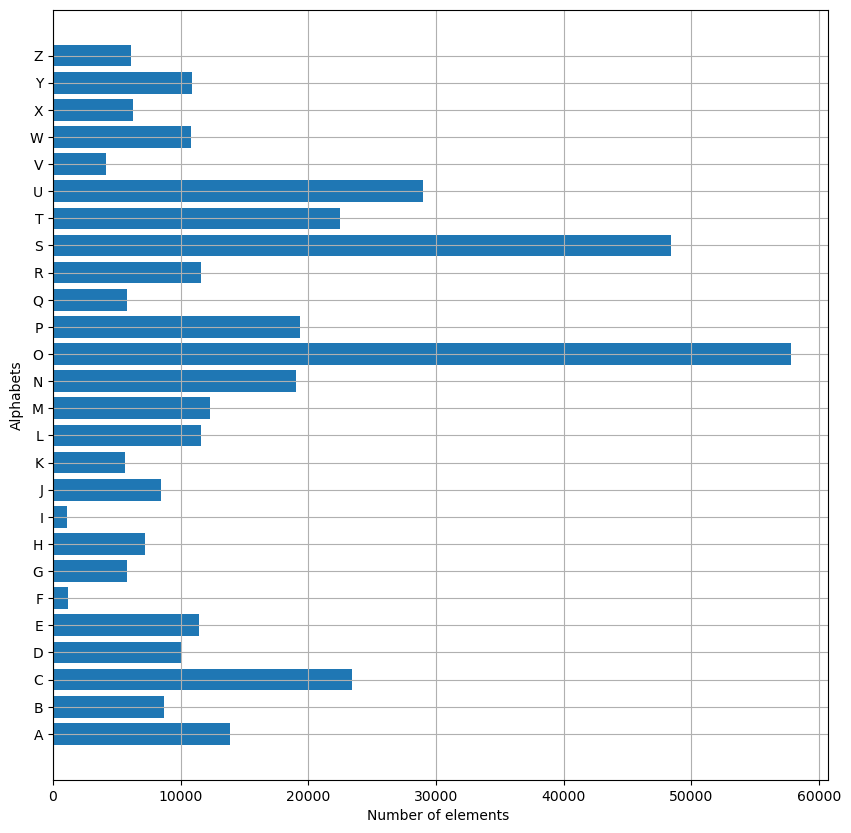

In [7]:
train_yint = np.int0(y)
count = np.zeros(26, dtype='int')
for i in train_yint:
    count[i] += 1

alphabets = []
for i in word_dict.values():
    alphabets.append(i)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.barh(alphabets, count)

plt.xlabel("Number of elements ")
plt.ylabel("Alphabets")
plt.grid()
plt.show()

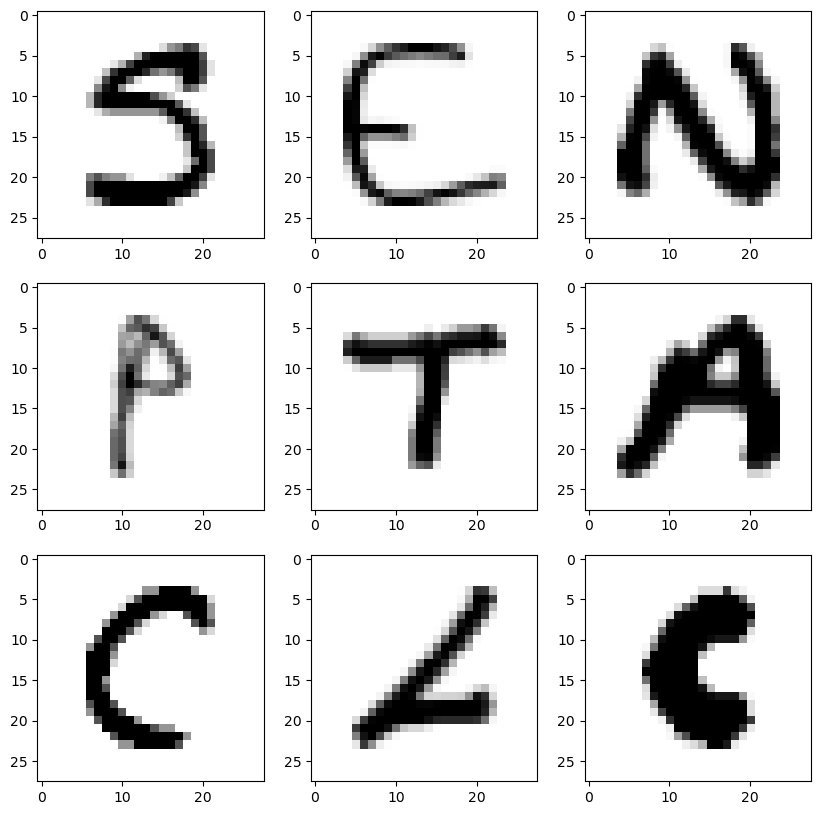

In [8]:
shuff = shuffle(train_x[:100])

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
axes = ax.flatten()

for i in range(9):
    axes[i].imshow(np.reshape(shuff[i], (28, 28)), cmap="Greys")
plt.show()

In [9]:
train_X = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
print("Новая размерность тренировочной выборки: ", train_X.shape)

test_X = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)
print("Новая размерность тестовой выборки: ", test_X.shape)

Новая размерность тренировочной выборки:  (297960, 28, 28, 1)
Новая размерность тестовой выборки:  (74490, 28, 28, 1)


In [10]:
train_yOHE = to_categorical(train_y, num_classes=26, dtype='int')
test_yOHE = to_categorical(test_y, num_classes=26, dtype='int')

In [11]:
try:
    model = keras.models.load_model('./saved_model.h5')
except:
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())

    model.add(Dense(64, activation="relu"))
    model.add(Dense(128, activation="relu"))

    model.add(Dense(26, activation="softmax"))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

    history = model.fit(train_X, train_yOHE, epochs=1, callbacks=[reduce_lr, early_stop],
                        validation_data=(test_X, test_yOHE))

    model.summary()
    model.save(r'saved_model.h5')

In [12]:
print("Точность при проверке:", history.history['val_accuracy'])
print("Точность при обучении:", history.history['accuracy'])
print("Ошибка при проверке:", history.history['val_loss'])
print("Ошибка при обучении:", history.history['loss'])

NameError: name 'history' is not defined

In [13]:
pred = model.predict(test_X[:9])
print(test_X.shape)

(74490, 28, 28, 1)


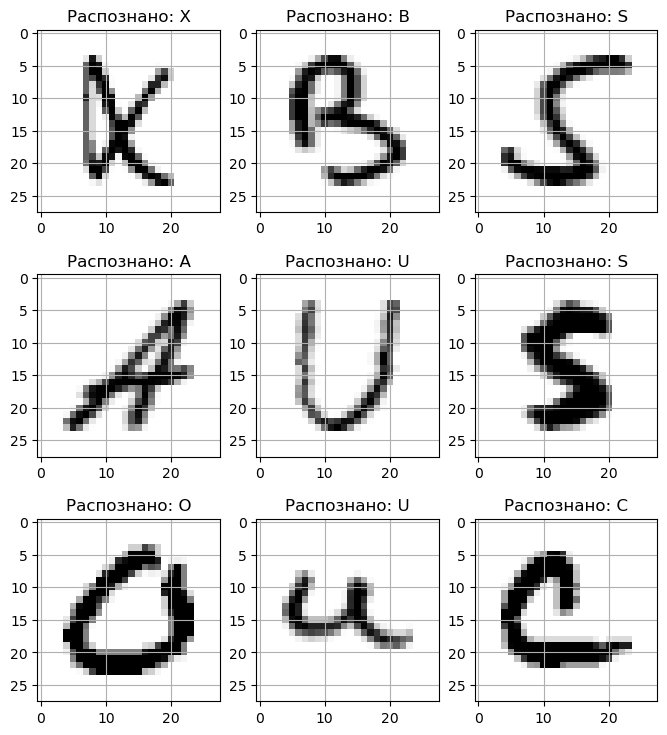

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(8, 9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = np.reshape(test_X[i], (28, 28))
    ax.imshow(img, cmap="Greys")
    pred = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Распознано: " + pred)
    ax.grid()

In [60]:
# Поменяй путь на свой, нормальный!!
img = cv2.imread(r'C:\Users\Dmitry\Pictures\Z.png')
img_copy = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400, 440))

img_copy = cv2.GaussianBlur(img_copy, (7, 7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28, 28))
img_final = np.reshape(img_final, (1, 28, 28, 1))

img_pred = word_dict[np.argmax(model.predict(img_final))]

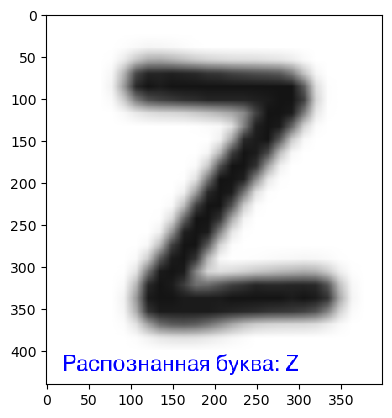

In [78]:
pil_image = Image.fromarray(img)

font = ImageFont.truetype("Pragmatica-Book.ttf", 26)
draw = ImageDraw.Draw(pil_image)
draw.text((20, 400), f"Распознанная буква: {img_pred}", font=font, fill=(255,0,0,255))

image = np.asarray(pil_image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)